# Path e librerie
## Prima di modificare avvertire gli altri!

## Install

In [ ]:
#import drive dir
from google.colab import drive
drive_dir = 'drive' ; 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install polyglot
!pip install PyICU
!pip install pycld2
!pip install morfessor

     |████████████████████████████████| 126 kB 36.1 MB/s 
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52578 sha256=c68973e90de9d5f9b15413528324cf6d21c8a0412fb9b18a2e1eaba207d3672f
  Stored in directory: /root/.cache/pip/wheels/09/bc/67/75c9de8e9726460bc0b101ad225ad025cb8ce9e0759beb9d52
Successfully built polyglot
     |████████████████████████████████| 299 kB 32.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for PyICU: filename=PyICU-2.8-cp37-cp37m-linux_x86_64.whl size=1377130 sha256=bdf61be8cbae56ae2a9edd0b60b63d86986055d1ff951949689dfe8758539d5f
  Stored in directory: /root/.cache/pip/wheels/14/bd/45/aeddc643bd0637c14fa27bffaee5b411cdc323f8bec76ad15e
Successfully built PyICU
     |████████████████████████████████| 41.4 MB 1.2 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834313 sha256=6ae377d465a1c69830

## Import

In [ ]:
import tweepy
import numpy as np
from tweepy import Stream, OAuthHandler
from tqdm.notebook import tqdm
# from tqdm import tqdm !! per Jupyter from tqdm.notebook non funziona, runnare questo
import pandas as pd
pd.set_option('display.max_colwidth', None) # setta il num. di caratteri visibili per ogni cella della colonna
# es. 50 = primi 50 caratteri
# None = testo completo

import io
import pprint
import os
import glob
import warnings
warnings.filterwarnings('ignore')

from polyglot.detect import Detector
import icu
import csv
import re

## Path per Colab

In [ ]:
##########################
### ROOT
##########################

prj_root_dir = f'/content/{drive_dir}/MyDrive/nucleare/'
os.makedirs(prj_root_dir, exist_ok=True)

##########################
### SCRAPING: file dello scraping di ATP
##########################

scrapingATP_root_dir = prj_root_dir + 'scrapingATP/'
os.makedirs(scrapingATP_root_dir, exist_ok=True)

##########################
### ETL: 
##########################

etl_root_dir = prj_root_dir + 'ETL/'
os.makedirs(etl_root_dir, exist_ok=True)

##########################
### DWH
##########################

dw_root_dir = prj_root_dir + 'DWH/'
os.makedirs(dw_root_dir, exist_ok=True)

##########################
### SENTIMENT
##########################

sentiment_root_dir = prj_root_dir + 'SENTIMENT/'
os.makedirs(sentiment_root_dir, exist_ok=True)

##########################
### WORDEMBEDDING
##########################

embedding_root_dir = prj_root_dir + 'EMBEDDING/'
os.makedirs(embedding_root_dir, exist_ok=True)

##########################
### OUTPUT
##########################

output_root_dir = prj_root_dir + 'OUTPUT/'
os.makedirs(output_root_dir, exist_ok=True)

##########################
### MODELS
##########################

models_root_dir = prj_root_dir + 'MODELS/'
os.makedirs(models_root_dir, exist_ok=True)

##########################
### STAGING ANTONELLO M.
##########################

st_man_root_dir = prj_root_dir + 'STAGING_MANENTI/'
os.makedirs(st_man_root_dir, exist_ok=True)


##########################
### STAGING TONE
##########################

st_tone_root_dir = prj_root_dir + 'STAGING_TONE/'
os.makedirs(st_tone_root_dir, exist_ok=True)

##########################
### STAGING MARCO
##########################

st_marco_root_dir = prj_root_dir + 'STAGING_MARCO/'
os.makedirs(st_marco_root_dir, exist_ok=True)

##########################
### STAGING NATALIA
##########################

st_natalia_root_dir = prj_root_dir + 'STAGING_NATALIA/'
os.makedirs(st_natalia_root_dir, exist_ok=True)

### Path per Jupyter
Solo quando si usa Jupyter runnare, il percorso dovrebbe essere lo stesso per tutti/e

In [ ]:
##########################
### ROOT
##########################

drive_dir = f'G:\\My Drive'
prj_root_dir = f'{drive_dir}\\nucleare\\'

##########################
### SCRAPING
##########################

scrapingATP_root_dir = prj_root_dir + 'scrapingATP\\'

##########################
### ETL
##########################

etl_root_dir = prj_root_dir + 'ETL\\'

##########################
### DWH
##########################

dw_root_dir = prj_root_dir + 'DWH\\'

##########################
### SENTIMENT
##########################

sentiment_root_dir = prj_root_dir + 'SENTIMENT\\'

##########################
### WORDEMBEDDING
##########################

embedding_root_dir = prj_root_dir + 'EMBEDDING\\'

##########################
### OUTPUT
##########################

output_root_dir = prj_root_dir + 'OUTPUT\\'

##########################
### STAGING ANTONELLO M.
##########################

st_man_root_dir = prj_root_dir + 'STAGING_MANENTI\\'

# 1. INGEST
## Antonello

cartella di scraping: nulceare/scrapingATP

## Codici Twitter

In [ ]:
consumer_key = 'WYOB4KubrmdOM9ycdyGvBLkTa'# API Key
consumer_secret = 'AThpoW6fKDm6bwZYeO0C0AVM7jKVq0bVgU7w9VfMejrnkygBTK' # APY Secret Key
access_token = '1396896479525097474-2HgbagRtx3ByeO4zmkWSPaL1iOxEiH'
access_secret = 'IKvhdjwGMDky2dAN6OYdeMZhWUHYheqTmMEWdgcInXf4F'
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

# consumer_key = 'MQXChIn29dCky3pOQyW890Uxi'
# consumer_secret = 'u4n3UeFz58b4H6InWFhBDUPZsfJ8xdVS0wODdnfAjz6e6PUbCJ'
# access_token = '262247836-oWkm6AZIw4K0Fldnt8VBXwuL9IbtNCZwVj73ODkI'
# access_secret = 'GySGl7BGaYvmXUtCapu5pHwEDHD5tA3Qd4yCMIDPKm1Wx'
# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)
# api = tweepy.API(auth, wait_on_rate_limit=True)

# consumer_key = 'Vzk6O5t967f1n4iz9iQcsQwhf'
# consumer_secret = 'Q8sncdY1j85mwNitOqb5Spcg6U6uuZ0E2KNHHZEYF2J4DdCyVi'
# access_token = '164224789-mFmU5YhessCNvubNojgfL605tbU0vh0NOna3HdQU'
# access_secret = 'Ic5LNOH2QqxziSq4eTQdJvbXo3noTcQDUzCKXgFcdPzpC'
# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)
# api = tweepy.API(auth, wait_on_rate_limit=True)

# consumer_key = 'A4GRiWdUDgiGPckQSykzA'
# consumer_secret = 'nSyjpFDTr3eEmd8tFeBM1lwVrTNPLaHrcx0DicTEEuw'
# access_token = '1678747572-lbkg1jxpe5HypoTRSnRMeiVIe0RBMxhdjLJ0GJ6'
# access_secret = '1qVP0pHXV9HDgKhHDIy2HHqqnHFBm3sI5AR2ZDwZxlM'
# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)
# api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
utente = 'antonello' #mettere il proprio nome
lang = 'all' #mettere la lingua
prog = '20' #mettere il progressivo

## Scraping dello storico

In [ ]:
#mettere la query
query_00 = ('NittoATPFinals' or 'TennisTakesOverTorino' or '#ATPFinals' or 'ATPFinals' or 'ATP Finals' or 'Norrie' or '#Norrie' or '@cam_norrie' or 'Norrie' or '#Norrie' or '@cam_norrie' or 'Ruud' or '#Ruud' or '@CasperRuud98' or 'Rublev' or '#Rublev' or '@AndreyRublev97' or 'Tsitsipas' or '#Tsitsipas' or '@steftsitsipas' or 'Djokovic' or '#Djokovic' or '@DjokerNole' or 'Sinner' or '#Sinner' or '@janniksin' or 'Medvedev' or '#Medvedev' or '@DaniilMedwed' or 'Zverev' or '#Zverev' or '@AlexZverev' 'Berrettini' or '#Berrettini' or '@MattBerrettini' or 'Hurkacz' or '#Hurkacz' or '@HubertHurkacz')
query_01 = ('@DaniilMedwed' or 'Medvedev' or '#Medvedev' or '@AlexZverev' or 'Zverev' or '#Zverev' or '#NittoATPFinals' or 'NittoATPFinals' or 'TennisTakesOverTorino' or '#ATPFinals' or 'ATPFinals' or 'ATP Finals')

In [ ]:
searched_tweets = []
last_id = -1
max_tweets = 500_000
pbar = tqdm(total=max_tweets)

while len(searched_tweets) < max_tweets:
    count = max_tweets - len(searched_tweets)
    try:
        # api.search è un metodo che su colab funziona anche se non è documentato in Tweepy. Su Jupyter non funziona, sostituire con search_tweets
        new_tweets = api.search(q=query_01, count=1000, max_id=str(last_id - 1), tweet_mode="extended") # tweet_mode="extended" importante, altrimenti il testo del tweet viene troncato
        # If I've reached the end of the search then I'm done
        # immediately the cycle while
        if not new_tweets:
            break
        # added the data found to the list
        searched_tweets.extend(new_tweets)
        # tqdm
        pbar.update(len(new_tweets))
        # retrieve the last id found
        last_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        print(e)
        break

pbar.close()

In [ ]:
print('Totale Tweet')
len(searched_tweets)

In [ ]:
dict_ = {'id': [], 'user': [], 'date': [], 'text': [], 
         'favorite_count': [], 'hashtags': [], 
         'location': [], 'retweet': [], 'retweet_count': [], 'followers_count': [], 'in_reply_to_status_id':[], 'user_mentions':[]}

for status_j in searched_tweets[0:max_tweets]:
    status = status_j._json

    if 'retweeted_status' in status:
      if 'extended_tweet' in status['retweeted_status']:
        text = status['retweeted_status']['extended_tweet']['full_text']
        dict_['text'].append(text)
      else:
        text = status['retweeted_status']['full_text']
        dict_['text'].append(text)
    else:
      if 'extended_tweet' in status:
        text = status['extended_tweet']['full_text']
        dict_['text'].append(text)
      else:
        text = status['full_text']
        dict_['text'].append(text)
    
    dict_['id'].append(status['id'])
    dict_['user'].append(status['user']['screen_name'])
    dict_['hashtags'].append([hashtag['text'] for hashtag in status['entities']['hashtags']])
    dict_['user_mentions'].append([user_mention['screen_name'] for user_mention in status['entities']['user_mentions']])
    dict_['location'].append(status['user']['location'])
    dict_['followers_count'].append(status['user']['followers_count'])
    dict_['in_reply_to_status_id'].append(status['in_reply_to_status_id'])
    dict_['date'].append(status['created_at'])
    dict_['favorite_count'].append(status['favorite_count'])
    dict_['retweet_count'].append(status['retweet_count'])
    dict_['retweet'].append(status['retweeted'])

df = pd.DataFrame.from_dict(dict_, orient="columns")
df = df.set_index("id")
df.sort_values(by=['date'], inplace=True, ascending=True)
df.head(10)

In [ ]:
df = pd.DataFrame.from_dict(dict_, orient="columns")
df = df.set_index("id")
df.sort_values(by=['date'], inplace=True, ascending=True)
df.head(10)

In [ ]:
df.info()

In [ ]:
print(df.shape)

In [ ]:
df.to_csv(f'{scrapingATP_root_dir}twitter_history_{utente}_{prog}_{lang}_{len(searched_tweets)}.csv')

## Scraping dello stream

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    data = [] #qui ci metto i tweet che scarico man mano
    num = 0 #questo è un contatore settato a 0

    def store(self):
      dict_ = {'id': [], 'user': [], 'date': [], 'text': [],
         'favorite_count': [], 'hashtags': [], 
         'location': [], 'retweet': [], 'retweet_count': [], 'followers_count': [], 'in_reply_to_status_id':[], 'user_mentions':[]}
      
      for status_j in self.data:
          status = status_j._json

          if 'retweeted_status' in status:
            if 'extended_tweet' in status['retweeted_status']:
              text = status['retweeted_status']['extended_tweet']['full_text']
              dict_['text'].append(text)
            else:
              text = status['retweeted_status']['full_text']
              dict_['text'].append(text)
          else:
            if 'extended_tweet' in status:
              text = status['extended_tweet']['full_text']
              dict_['text'].append(text)
            else:
              text = status['full_text']
              dict_['text'].append(text)

          dict_['id'].append(status['id'])
          dict_['user'].append(status['user']['screen_name'])
          dict_['hashtags'].append([hashtag['text'] for hashtag in status['entities']['hashtags']])
          dict_['user_mentions'].append([user_mention['screen_name'] for user_mention in status['entities']['user_mentions']])
          dict_['location'].append(status['user']['location'])
          dict_['followers_count'].append(status['user']['followers_count'])
          dict_['in_reply_to_status_id'].append(status['in_reply_to_status_id'])
          dict_['date'].append(status['created_at'])
          dict_['full_text'].append(status['full_text'])
          dict_['favorite_count'].append(status['favorite_count'])
          dict_['retweet_count'].append(status['retweet_count'])
          dict_['retweet'].append(status['retweeted'])

      df = pd.DataFrame.from_dict(dict_, orient="columns")
      df = df.set_index("id")
      df.sort_values(by='favorite_count', inplace=True, ascending=False)
      df.to_csv(f'{scrapingATP_root_dir}_twitter_stream_{utente}_{prog}_{lang}_' + str(self.num) + '.csv') #salvo in csv
      self.num = self.num + 1
      self.data = []


    def on_status(self, status):
        self.data.append(status)
        # to pandas
        # store su google drive
        if len(self.data) > 5000:
          self.store()

In [ ]:
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener, tweet_mode="extended")

In [ ]:
query_00 = ('NittoATPFinals' or 'TennisTakesOverTorino' or '#ATPFinals' or 'ATPFinals' or 'ATP Finals' or 'Norrie' or '#Norrie' or '@cam_norrie' or 'Norrie' or '#Norrie' or '@cam_norrie' or 'Ruud' or '#Ruud' or '@CasperRuud98' or 'Rublev' or '#Rublev' or '@AndreyRublev97' or 'Tsitsipas' or '#Tsitsipas' or '@steftsitsipas' or 'Djokovic' or '#Djokovic' or '@DjokerNole' or 'Sinner' or '#Sinner' or '@janniksin' or 'Medvedev' or '#Medvedev' or '@DaniilMedwed' or 'Zverev' or '#Zverev' or '@AlexZverev' 'Berrettini' or '#Berrettini' or '@MattBerrettini' or 'Hurkacz' or '#Hurkacz' or '@HubertHurkacz')
query_01 = ['@DaniilMedwed' or 'Medvedev' or '#Medvedev' or '@AlexZverev' or 'Zverev' or '#Zverev' or '#NittoATPFinals' or 'NittoATPFinals' or 'TennisTakesOverTorino' or '#ATPFinals' or 'ATPFinals' or 'ATP Finals']
myStream.filter(track=query_01)

In [ ]:
len(myStreamListener.data)

In [ ]:
dict_ = {'id': [], 'user': [], 'date': [], 'text': [], 
         'favorite_count': [], 'hashtags': [], 
         'location': [], 'retweet': [], 'retweet_count': [], 'followers_count': [], 'in_reply_to_status_id':[], 'user_mentions':[]}
#
for status_j in myStreamListener.data:
    status = status_j._json

    if 'retweeted_status' in status:
      if 'extended_tweet' in status['retweeted_status']:
        text = status['retweeted_status']['extended_tweet']['full_text']
        dict_['text'].append(text)
      else:
        text = status['retweeted_status']['text']
        dict_['text'].append(text)
    else:
      if 'extended_tweet' in status:
        text = status['extended_tweet']['full_text']
        dict_['text'].append(text)
      else:
        text = status['text']
        dict_['text'].append(text)

    dict_['id'].append(status['id'])
    dict_['user'].append(status['user']['screen_name'])
    dict_['hashtags'].append([hashtag['text'] for hashtag in status['entities']['hashtags']])
    dict_['user_mentions'].append([user_mention['screen_name'] for user_mention in status['entities']['user_mentions']])
    dict_['location'].append(status['user']['location'])
    dict_['followers_count'].append(status['user']['followers_count'])
    dict_['in_reply_to_status_id'].append(status['in_reply_to_status_id'])
    dict_['date'].append(status['created_at'])
    dict_['favorite_count'].append(status['favorite_count'])
    dict_['retweet_count'].append(status['retweet_count'])
    dict_['retweet'].append(status['retweeted'])

In [ ]:
df = pd.DataFrame.from_dict(dict_, orient="columns")
df = df.set_index("id")
df.sort_values(by='favorite_count', inplace=True, ascending=False)
df.head(10)

In [ ]:
df.to_csv(f'{scrapingATP_root_dir}twitter_stream_{utente}_{prog}_{lang}_{len(myStreamListener.data)}.csv') #scarico l'ultimo stream

In [ ]:
#unisco tutti i csv

path = scrapingATP_root_dir

all_files = glob.glob(os.path.join(path, "twitter_*.csv"))
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True)
df_merged.drop_duplicates(subset=['id'], inplace=True, ignore_index=False)
df_merged.to_csv(f'{etl_root_dir}twitter_merged_from_scraping.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
df_merge = pd.read_csv(f'{etl_root_dir}twitter_merged_from_scraping.csv')
df_merge.info()

In [ ]:
df_merge.tail()

# 2. ETL
**NATALIA**



1.   rimuovere #
2.   rimuovere id doppi
1.   rimuovere http
2.   rimuovere twitter con testo vuoto
1.   rimuovere @



file input: nucleare/ETL/twitter_merged_from_scraping.csv

cartella output: nucleare/DWH/

In [ ]:
df = pd.read_csv(etl_root_dir+'twitter_merged_from_scraping.csv')

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [ ]:
with open(dw_root_dir+'twitter_text_cleaned.csv', mode='w') as csv_file_out:
  csv_writer_out = csv.writer(csv_file_out, delimiter=',', quotechar='"')
  with open(etl_root_dir+'twitter_merged_from_scraping.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    max_lines=10000000 
    monDict = {'Gen' : '01' , 'Feb' : '02', 'Mar' : '03', 'Apr' : '04', 'May' : '05', 'Jun' : '06', 'Jul' : '07', 'Aug' : '08', 'Sep' : '09', 'Oct' : '10', 'Nov' : '11', 'Dic' : '12'}
  
    for row in csv_reader:
          if line_count > 0:
              dateCur=row[2]
              monCur=monDict[dateCur[4:7]]
              dateNew=dateCur[26:30]+'-'+monDict[dateCur[4:7]]+'-'+dateCur[8:10]+' '+dateCur[11:13]+':'+dateCur[14:16]+':'+dateCur[17:19]
              timezone='z'+dateCur[20:25]
              #print (f'{dateCur} ==> {dateNew}')
              textnonl=row[3].replace("\n"," ")
              textnonl==re.sub(r"\s+"," ",textnonl) # tolgo doppi spazi
              #print (f'message {message}')
              textnonlhash=re.sub(r"#\w+ ?","",textnonl)
              textnonlhash=re.sub(r"\s+"," ",textnonlhash)
              textnonlhashmen=re.sub(r"@\w+ ?","",textnonlhash)
              textnonlhashmen=re.sub(r"\s+"," ",textnonlhashmen)
              textnonlhashmenhttp=re.sub(r"http\S+","",textnonlhashmen)
              textnonlhashmenhttp=re.sub(r"\s+"," ",textnonlhashmenhttp)
              textnonlhashmenhttpnum=re.sub(r"\d+", "", textnonlhashmenhttp)    
              textnonlhashmenhttpnum=re.sub(r"\s+"," ",textnonlhashmenhttpnum)
              textnonlhashmenhttpnumsimb=re.sub(r"[^\w\s]"," ",textnonlhashmenhttpnum)
              textnonlhashmenhttpnumsimb=re.sub(r"\s+"," ",textnonlhashmenhttpnumsimb)
              row2=row
              row2.extend([dateNew,timezone,textnonl,textnonlhash,textnonlhashmen,textnonlhashmenhttp,textnonlhashmenhttpnum,textnonlhashmenhttpnumsimb])
              csv_writer_out.writerow(row2)
              line_count += 1
          else:
            row2=row
            row2.extend(['date_norm','time_zone','text_nonl','text_nonl_hash','text_nonl_hash_men','text_nonl_hash_men_http','text_nonl_hash_men_http_num','text_nonl_hash_men_http_num_simb'])
            csv_writer_out.writerow(row2)
            line_count += 1
          if line_count > max_lines:
              print (f'Exit')
              break      
    print(f'Processed {line_count} lines.')

In [ ]:
df = pd.read_csv(dw_root_dir+'twitter_text_cleaned.csv', sep=',')
df.info()

# 3. LANGUAGE DETECTION
ANTONELLO M.

In [ ]:
df = pd.read_csv(f'{dw_root_dir}twitter_text_cleaned.csv')
df.info()

In [ ]:
df.sample(n=5, random_state=13)

In [ ]:
# testing polyglot
df_test = df[['text_nonl_hash_men_http_num_simb', 'text']]
df_test = df_test.sample(n=3, random_state=13)
df_test

In [ ]:
df_test['poly_obj'] = df_test.text_nonl_hash_men_http_num_simb.apply(lambda x: Detector(x, quiet=True))
df_test['text_lang'] = df_test.poly_obj.apply(lambda x: icu.Locale.getDisplayName(x.language.locale))
df_test['text_lan_code'] = df_test.poly_obj.apply( lambda x: x.language.code)
df_test['lang_confidence'] = df_test.poly_obj.apply( lambda x: x.language.confidence)

In [ ]:
df_test.info()

In [ ]:
df_test

In [ ]:
df_test['poly_obj'] = df_test['poly_obj'].astype(str)
df_test_predict = df_test['poly_obj'].str.split(" ", expand=True)
df_test_predict.rename(columns={3:'prediction'}, inplace=True)
df_test_predict = df_test_predict.drop([0, 1, 2, 4, 5, 6], axis=1)
df_test_predict = df_test_predict.iloc[:,0:1]
df_test_predict['prediction_reliable'] = df_test_predict['prediction'].str.replace(r'\n([-A-Za-z0-9_.]+)', '') 
df_test_predict = df_test_predict.drop(['prediction'], axis=1)
df_test = pd.concat([df_test, df_test_predict], axis=1) 
df_test = df_test.drop(['poly_obj'], axis=1)
df_test

In [ ]:
# apply polyglot
df = df[df['text_nonl_hash_men_http_num_simb'].notna()]
df['poly_obj'] = df['text_nonl_hash_men_http_num_simb'].apply(lambda x: Detector(x, quiet=True))
df['text_lang'] = df.poly_obj.apply(lambda x: icu.Locale.getDisplayName(x.language.locale))
df['text_lan_code'] = df.poly_obj.apply( lambda x: x.language.code)
df['lang_confidence'] = df.poly_obj.apply( lambda x: x.language.confidence)

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df['poly_obj'] = df['poly_obj'].astype(str)
df_det_lang = df['poly_obj'].str.split(" ", expand=True)
df_det_lang.rename(columns={3:'prediction'}, inplace=True)
df_det_lang = df_det_lang.drop([0, 1, 2, 4, 5, 6], axis=1)
df_det_lang = df_det_lang.iloc[:,0:1]
df_det_lang['prediction_reliable'] = df_det_lang['prediction'].str.replace(r'\n([-A-Za-z0-9_.]+)', '') 
df_det_lang = df_det_lang.drop(['prediction'], axis=1)
df = pd.concat([df, df_det_lang], axis=1) 
df = df.drop(['poly_obj'], axis=1)
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
twe = df['id'].count()
lan = df['text_lang'].nunique()
print(f'{lan} lingue differenti per {twe} tweet di cui:')
df.groupby(['text_lang']).size().nlargest(10).reset_index(name='top10')

In [ ]:
df.to_csv(f'{st_man_root_dir}twitter_text_cleaned_lang_det.csv', index=False)

# 4. PLAYER DETECTION
ANTONELLO M.

In [ ]:
df = pd.read_csv(f'{st_man_root_dir}twitter_text_cleaned_lang_det.csv')

In [ ]:
df.info()

**Idea**
1. Si creano tante colonne quante sono le variabili in list (cella iniziale)
2. Se una delle parole definite nella lista (.str.contains) è presente si mette 1 colonna corrispondente corrispondete.
3. Se la somma delle nuove colonne è 0 il topic è Other
4. Se la somma delle nuove colonne è 1 il topic è il nome della colonna con valore 1.
5. Se la somma delle nuove colonne è 2 e ATP Finals = 1 allora il topic è il nome dell'altra colonna
6. Se la somma delle nuove colonne è 2 e ATP Finals = 0 allora il topic è il nome previsto da match se le colonne corrispettive sono a 1, altrimenti il topic è il nome di entrambi i giocatori.
7. Se la somma delle nuove colonne è 3 e ATP Finals = 1 allora il topic è il nome previsto da match se le colonne corrispettive sono a 1, altrimenti il topic è il nome di tutti i giocatori = 1.
8. Se la somma delle nuove colonne è 3 e ATP Finals = 0 il topic sono tutti i nomi dei giocatori = 1.
9. Se la somma delle nuove colonne è > 3 il topic è il nome di tutti i giocatori = 1


**Match**

Djokovic and Ruud = 'Djokovic VS Ruud RR' # RR is Round Robin cioè fase a gironi

Rublev and Tsitsipas = 'Rublev VS Tsitsipas RR'

Djokovic and Rublev = 'Djokovic VS Rublev RR'

Ruud and Norrie = 'Ruud VS Norrie RR'

Ruud and Rublev = 'Ruud VS Rublev RR'

Djokovic and Norrie = 'Djokovic VS Norrie RR'

Medvedev and Hurkacz = 'Medvedev VS Hurkacz RR'

Zverev and Berrettini = 'Zverev VS Berrettini RR'

Medvedev and Zverev = 'Medvedev VS Zverev RR'

Sinner and Hurkacz = 'Sinner VS Hurkacz RR'

Zverev and Hurkacz = 'Zverev VS Hurkacz RR'

Medvedev and Sinner = 'Medvedev VS Sinner RR'

Djokovic and Zverev = 'Djokovic VS Zverev SF' # SF is Semi-Final

Medvedev and Ruud = 'Medvedev VS Ruud SF'

Medvedev and Zverev = 'Medvedev VS Zverev F' #F is Final

In [ ]:
# inizio definendo per ogni topic le cose che deve contenere
Medvedev = ['Medvedev', '#Medvedev', '@DaniilMedwed']
Zverev = ['Zverev', '#Zverev', '@AlexZverev']
Berrettini = ['Berrettini', '#Berrettini', '@MattBerrettini']
Hurkacz = ['Hurkacz', '#Hurkacz', '@HubertHurkacz']
Sinner = ['Sinner', '#Sinner', '@janniksin']
Djokovic = ['Djokovic', '#Djokovic', '@DjokerNole']
Tsitsipas = ['Tsitsipas', '#Tsitsipas', '@steftsitsipas']
Rublev = ['Rublev', '#Rublev', '@AndreyRublev97']
Ruud = ['Ruud', '#Ruud', '@CasperRuud98']
Norrie = ['Norrie', '#Norrie', '@cam_norrie']
ATP_Finals = ['NittoATPFinals', 'TennisTakesOverTorino', '#ATPFinals', 'ATPFinals']

In [ ]:
# creo le colonne con valori 1 e 0
df['Medvedev'] = np.where(df['text'].str.contains('|'.join(Medvedev)), 1, 0)
df['Zverev'] = np.where(df['text'].str.contains('|'.join(Zverev)), 1, 0)
df['Berrettini'] = np.where(df['text'].str.contains('|'.join(Berrettini)), 1, 0)
df['Hurkacz'] = np.where(df['text'].str.contains('|'.join(Hurkacz)), 1, 0)
df['Sinner'] = np.where(df['text'].str.contains('|'.join(Sinner)), 1, 0)
df['Djokovic'] = np.where(df['text'].str.contains('|'.join(Djokovic)), 1, 0)
df['Tsitsipas'] = np.where(df['text'].str.contains('|'.join(Tsitsipas)), 1, 0)
df['Rublev'] = np.where(df['text'].str.contains('|'.join(Rublev)), 1, 0)
df['Ruud'] = np.where(df['text'].str.contains('|'.join(Ruud)), 1, 0)
df['Norrie'] = np.where(df['text'].str.contains('|'.join(Norrie)), 1, 0)
df['ATP_Finals'] = np.where(df['text'].str.contains('|'.join(ATP_Finals)), 1, 0)

In [ ]:
df_topic = df[["ATP_Finals", "Sinner", "Norrie", "Ruud", "Rublev", "Tsitsipas", "Medvedev", "Zverev", "Berrettini", "Hurkacz", "Djokovic"]]
df_topic_NO_ATP = df[["Sinner", "Norrie", "Ruud", "Rublev", "Tsitsipas", "Medvedev", "Zverev", "Berrettini", "Hurkacz", "Djokovic"]]

df['topic'] = df_topic_NO_ATP.apply(lambda row: row[row == 1].index.values, axis=1)

In [ ]:
# df = df.drop(['ATP_Finals', 'Norrie', 'Ruud', 'Medvedev', 'Zverev', 'Berrettini', 'Hurkacz', 'Sinner', 'Djokovic', 'Tsitsipas', 'Rublev'], axis=1)
df.to_csv(f'{st_man_root_dir}twitter_text_cleaned_lang_and_player_det.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
# per staging Marco 2 subset: it e en
df_en = df[df["text_lang"].str.contains("English")]
df_it = df[df["text_lang"].str.contains("Italian")]

In [ ]:
print(df_en.shape)
print(df_it.shape)

In [ ]:
df_en.info()

In [ ]:
df_it.info()

In [ ]:
df_en.head()

In [ ]:
df_it.head()

In [ ]:
# to stagin Ant M.
df_en.to_csv(f'{st_man_root_dir}twitter_text_cleaned_lang_and_player_det_EN.csv', index=False, sep=',', encoding='utf-8')
df_it.to_csv(f'{st_man_root_dir}twitter_text_cleaned_lang_and_player_det_IT.csv', index=False, sep=',', encoding='utf-8')

# to staging Marco
df_en.to_csv(f'{st_marco_root_dir}twitter_text_cleaned_lang_and_player_det_EN.csv', index=False, sep=',', encoding='utf-8')
df_it.to_csv(f'{st_marco_root_dir}twitter_text_cleaned_lang_and_player_det_IT.csv', index=False, sep=',', encoding='utf-8')

## Labeling

In [ ]:
# creare prima il subset che interessa e lo salvo per salvare il seme
# una volta fatto commentare queste celle
# ATTENZIONE già fatto, lasciare commentate!

# df = pd.read_csv(f'{st_man_root_dir}twitter_text_cleaned_lang_and_player_det_IT.csv')
# df_label = df.sample(n=2000) #frac=0.7
# df_label.to_csv(f'{st_man_root_dir}sample_2000_for_labeling_IT.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
# riprendo da qui il sample generato sopra
df_label = pd.read_csv(f'{st_man_root_dir}sample_2000_for_labeling_IT.csv')

In [ ]:
df_label.shape

In [ ]:
# divido il df in pezzi da 100 e procedo in ordine
label_100 = df_label.iloc[:100,:] # fatto
label_200 = df_label.iloc[100:200,:] # fatto
label_300 = df_label.iloc[200:300,:] # fatto
label_400 = df_label.iloc[300:400,:] # fatto
label_500 = df_label.iloc[400:500,:] # fatto
label_600 = df_label.iloc[500:600,:] # fatto
label_700 = df_label.iloc[600:700,:] # fatto
label_800 = df_label.iloc[700:800,:] # fatto
label_900 = df_label.iloc[800:900,:] # fatto
label_1000 = df_label.iloc[900:1000,:] # fatto
label_1100 = df_label.iloc[1000:1100,:] # fatto
label_1200 = df_label.iloc[1100:1200,:]
label_1300 = df_label.iloc[1200:1300,:]
label_1400 = df_label.iloc[1300:1400,:]
label_1500 = df_label.iloc[1400:1500,:]
label_1600 = df_label.iloc[1500:1600,:]
label_1700 = df_label.iloc[1600:1700,:]
label_1800 = df_label.iloc[1700:1800,:]
label_1900 = df_label.iloc[1800:1900,:]
label_2000 = df_label.iloc[1900:2000,:]

In [ ]:
# creo una lista vuota
sentiment = []
count = 1
# cambiare label_ ad ogni giro (1 occorrenza)
for b in tqdm(label_1100.text_nonl_hash_men_http_num):
  print()
  print(count)
  print(b)
  add_sent = input('1=pos, 0=neg, 2=neu: ')
  add_sent = add_sent.strip(' ')
  sentiment.append(add_sent)
  count += 1

# cambiare label_ ad ogni giro (1 occorrenza)
label_1100['sentiment'] = sentiment

In [ ]:
# cambiare label_ ad ogni giro (2 occorrenze)
label_1100.to_csv(f'{st_man_root_dir}label_1100_IT.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
# merge di tutti i label fatti

path = st_man_root_dir

all_files = glob.glob(os.path.join(path, "label_*.csv"))
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True)

# per sicurezza
df_merged.drop_duplicates(subset=['id'], inplace=True, ignore_index=False)
df_merged.dropna(subset=['sentiment'], inplace=True)

df_merged.to_csv(f'{st_tone_root_dir}label_IT.csv', index=False, sep=',', encoding='utf-8')
df_merged.to_csv(f'{st_natalia_root_dir}label_IT.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
df_merged.shape

In [ ]:
df_merged.info()

In [ ]:
df_merged.head()

# 5. SENTIMENT
MARCO

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 15.8 MB/s 


## Importo Dataset

In [ ]:
import pandas as pd
dfen = pd.read_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/Twitter_Manenti_Files/twitter_text_cleaned_lang_and_player_det_EN.csv')
dfen.shape

(49252, 36)

In [ ]:
dfit = pd.read_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/Twitter_Manenti_Files/twitter_text_cleaned_lang_and_player_det_IT.csv')
dfit.shape

(15985, 36)

## Vader En

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


vader=[]

analyzer = SentimentIntensityAnalyzer()

for x in (dfen.loc[:,'text_nonl_hash_men_http_num']):
  a = analyzer.polarity_scores(x)
  vader.append(a)

In [ ]:
df2 = pd.DataFrame(vader)
df2.shape

(49252, 4)

In [ ]:
print(df2)
df2.to_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/Vader_en.csv')

         neg    neu    pos  compound
0      0.145  0.681  0.174    0.1759
1      0.104  0.563  0.333    0.7430
2      0.000  1.000  0.000    0.0000
3      0.104  0.563  0.333    0.7430
4      0.145  0.681  0.174    0.1759
...      ...    ...    ...       ...
49247  0.000  0.740  0.260    0.6784
49248  0.000  1.000  0.000    0.0000
49249  0.062  0.684  0.254    0.7845
49250  0.000  1.000  0.000    0.0000
49251  0.320  0.680  0.000   -0.5093

[49252 rows x 4 columns]


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/Vader_en.csv')
df2.head(4)

,Unnamed: 0,neg,neu,pos,compound
0,0,0.145,0.681,0.174,0.1759
1,1,0.104,0.563,0.333,0.7430
2,2,0.000,1.000,0.000,0.0000
3,3,0.104,0.563,0.333,0.7430


## MERGE -- csv_tradotti

In [ ]:
import os
import glob
import pandas as pd
os.chdir("/content/drive/MyDrive/nucleare/STAGING_MARCO/PYTHON_TRADOTTI")

In [ ]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

df1 = pd.read_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/PYTHON_TRADOTTI/combined_csv.csv')
df1.head(1)

,text_nonl_hash_men_http_num
0,"We never wanted to see you like this, Matthew 💔 you're great, you'll be stronger than before🎾 | |"


## Vader it

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


vader=[]

analyzer = SentimentIntensityAnalyzer()

for x in (df1.loc[:,'text_nonl_hash_men_http_num']):
  a = analyzer.polarity_scores(x)
  vader.append(a)

In [ ]:
df1 = pd.DataFrame(vader)
df1.shape

(10000, 4)

In [ ]:
print(df1)
df1.to_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/Vader_it.csv')

        neg    neu    pos  compound
0     0.095  0.492  0.412    0.8834
1     0.000  1.000  0.000    0.0000
2     0.000  1.000  0.000    0.0000
3     0.262  0.738  0.000   -0.4926
4     0.000  0.909  0.091    0.4588
...     ...    ...    ...       ...
9995  0.090  0.910  0.000   -0.4847
9996  0.000  1.000  0.000    0.0000
9997  0.274  0.726  0.000   -0.6007
9998  0.091  0.909  0.000   -0.2960
9999  0.059  0.722  0.219    0.7424

[10000 rows x 4 columns]


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/Vader_it.csv')
df1.head(4)

,Unnamed: 0,neg,neu,pos,compound
0,0,0.095,0.492,0.412,0.8834
1,1,0.000,1.000,0.000,0.0000
2,2,0.000,1.000,0.000,0.0000
3,3,0.262,0.738,0.000,-0.4926


## MERGE DATASET 

In [ ]:
result_merge_it = pd.concat([dfit, df1], axis=1).reindex(dfit.index)
result_merge_it.head(1)
result_merge_it.shape

In [ ]:
result_merge_it.to_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/vader_merge_it.csv')

In [ ]:
result_merge_en = pd.concat([dfen, df2], axis=1).reindex(dfen.index)
result_merge_en.head(1)
result_merge_en.shape

(49252, 41)

In [ ]:
result_merge_en.to_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/vader_merge_en.csv')

In [ ]:
prot_new_dataset = result_merge_it.append(result_merge_en)
prot_new_dataset.shape

(65237, 41)

In [ ]:
prot_new_dataset.to_csv('/content/drive/MyDrive/nucleare/STAGING_MARCO/new_dataset.csv')

In [ ]:
prot_new_dataset.head(1)

,id,user,date,text,favorite_count,hashtags,location,retweet,retweet_count,followers_count,in_reply_to_status_id,user_mentions,date_norm,time_zone,text_nonl,text_nonl_hash,text_nonl_hash_men,text_nonl_hash_men_http,text_nonl_hash_men_http_num,text_nonl_hash_men_http_num_simb,text_lang,text_lan_code,lang_confidence,prediction_reliable,Medvedev,Zverev,Berrettini,Hurkacz,Sinner,Djokovic,Tsitsipas,Rublev,Ruud,Norrie,ATP_Finals,topic,Unnamed: 0,neg,neu,pos,compound
0,1460367628070014991,MaricieloCuore,Mon Nov 15 22:02:29 +0000 2021,"Non avremmo mai voluto vederti così, Matteo 💔\n\nSei grande, tornerai più forte di prima 💪🎾\n\n#Berrettini | #NittoATPFinals | #EurosportTENNIS https://t.co/vj9Zv7tlQm",0,"['Berrettini', 'NittoATPFinals']",NaN,False,60,45,NaN,['Eurosport_IT'],2021-11-15 22:02:29,z+0000,"Non avremmo mai voluto vederti così, Matteo 💔 Sei grande, tornerai più forte di prima 💪🎾 #Berrettini | #NittoATPFinals | #EurosportTENNIS https://t.co/vj9Zv7tlQm","Non avremmo mai voluto vederti così, Matteo 💔 Sei grande, tornerai più forte di prima 💪🎾 | | https://t.co/vj9Zv7tlQm","Non avremmo mai voluto vederti così, Matteo 💔 Sei grande, tornerai più forte di prima 💪🎾 | | https://t.co/vj9Zv7tlQm","Non avremmo mai voluto vederti così, Matteo 💔 Sei grande, tornerai più forte di prima 💪🎾 | |","Non avremmo mai voluto vederti così, Matteo 💔 Sei grande, tornerai più forte di prima 💪🎾 | |",Non avremmo mai voluto vederti così Matteo Sei grande tornerai più forte di prima,Italian,it,98.0,True,0,0,1,0,0,0,0,0,0,0,1,['Berrettini'],0.0,0.095,0.492,0.412,0.8834


# 6. TIMELINE

#### Apro il file con i Tweet labellati e solo in inglese e in italiano

In [ ]:
filepath='/content/drive/MyDrive/nucleare/STAGING_MARCO/'

In [ ]:
df = pd.read_csv(filepath+'new_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65237 entries, 3672 to 65236
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                65237 non-null  int64  
 1   user                              65237 non-null  object 
 2   date                              65237 non-null  object 
 3   text                              65237 non-null  object 
 4   favorite_count                    65237 non-null  int64  
 5   hashtags                          65237 non-null  object 
 6   location                          39321 non-null  object 
 7   retweet                           65237 non-null  bool   
 8   retweet_count                     65237 non-null  int64  
 9   followers_count                   65237 non-null  int64  
 10  in_reply_to_status_id             8328 non-null   float64
 11  user_mentions                     65237 non-null  object 
 12  d

#### Osservo che gli orari sono riferiti tutti all'ora di Greenwich

In [ ]:
df['time_zone'].value_counts()

z+0000    84310
Name: time_zone, dtype: int64

#### Sistemo il dataframe

In [ ]:
df=df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [ ]:
df['predicted'] = df['compound'].apply(lambda c: '1' if c >=0 else '0')
df.head()

In [ ]:
df=df.sort_values("date_norm")

In [ ]:
df['text_lan_code'].value_counts()

en    49252
it    15985
Name: text_lan_code, dtype: int64

#### Apro il file con i Tweet in tutte le lingue

In [ ]:
dftot = pd.read_csv(filepath+'twitter_text_cleaned.csv', sep=',')

In [ ]:
dftot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84912 entries, 18365 to 84911
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                84912 non-null  int64  
 1   user                              84912 non-null  object 
 2   date                              84912 non-null  object 
 3   text                              84912 non-null  object 
 4   favorite_count                    84912 non-null  int64  
 5   hashtags                          84912 non-null  object 
 6   location                          50798 non-null  object 
 7   retweet                           84912 non-null  bool   
 8   retweet_count                     84912 non-null  int64  
 9   followers_count                   84912 non-null  int64  
 10  in_reply_to_status_id             11407 non-null  float64
 11  user_mentions                     84912 non-null  object 
 12  

In [ ]:
dftot=dftot.sort_values("date_norm")

#### Creo gli istogrammi

2000
2001
maxhist_date_time 18/11/2021, 22:38:52
4 highest number of tweets: [1432. 1327. 1278.  993.]
their date ranges: [('18/11/2021, 22:38:52', '18/11/2021, 22:47:52'), ('16/11/2021, 21:38:08', '16/11/2021, 21:47:08'), ('21/11/2021, 17:29:46', '21/11/2021, 17:38:46'), ('20/11/2021, 22:36:39', '20/11/2021, 22:45:38')]


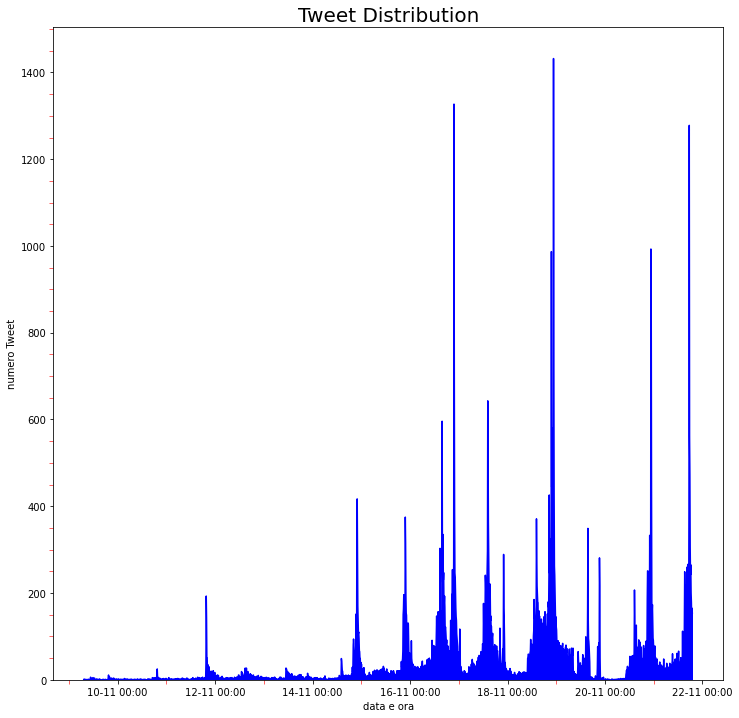

In [ ]:
import matplotlib.dates as mdates
# from datetime import datetime
# from matplotlib.ticker import MultipleLocator
# import matplotlib.ticker as ticker
# import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.cbook as cbook
# from dateutil import tz

days=mdates.DayLocator() # every day
hours=mdates.HourLocator()
datetimes= pd.to_datetime(dftot['date_norm'], format="%Y-%m-%d %H:%M:%S")
dates = mdates.date2num(datetimes)
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))
n, bins, patches =ax.hist(dates, bins=2000, color='blue')
print(n.size)
print(bins.size)
ax.plot(bins[:-1], n, color='blue')
idx_histmax = np.where(n == n.max())
maxhistbin = mdates.num2date(bins[idx_histmax][0])
maxhist_date_time = maxhistbin.strftime("%d/%m/%Y, %H:%M:%S")
print('maxhist_date_time', maxhist_date_time)
order = np.argsort(n)[::-1]#
ranges=[((mdates.num2date(bins[i])).strftime("%d/%m/%Y, %H:%M:%S"), (mdates.num2date(bins[i+1])).strftime("%d/%m/%Y, %H:%M:%S"))   for i in order[:4]]
print("4 highest number of tweets:", n[order][:4])
print("their date ranges:", ranges)
#print("  their ranges:", [ (bins[i], bins[i+1])   for i in order[:4]])
plt.gca().set(ylabel = 'numero Tweet',xlabel = 'data e ora')
#ax.yaxis.grid()
#plt.grid()
# remove the minor xtick labels set by pandas.plot
#ax2.set_xticklabels([], minor = True)
# turn the minor ticks created by pandas.plot off
plt.minorticks_on()
# Define the date format
date_form = mdates.DateFormatter("%d-%m %H:%M")
ax.xaxis.set_major_formatter(date_form)
#ax.xaxis.set_minor_formatter(date_form)
ax.xaxis.set_minor_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.tick_params(which='minor', length=4, color='r')
plt.title('Tweet Distribution', fontsize=20)
plt.show()

In [ ]:
df_p = df[df['predicted']=='1']

maxbin 18/11/2021, 19:20:18
4 highest bins: [4779. 4763. 4464. 4067.]
  their ranges: [(738112.8057694444, 738112.9304335648), (738115.673044213, 738115.7977083334), (738112.9304335648, 738113.0550976852), (738110.8111435185, 738110.9358076389)]
date and time: 18/11/2021, 19:20:18


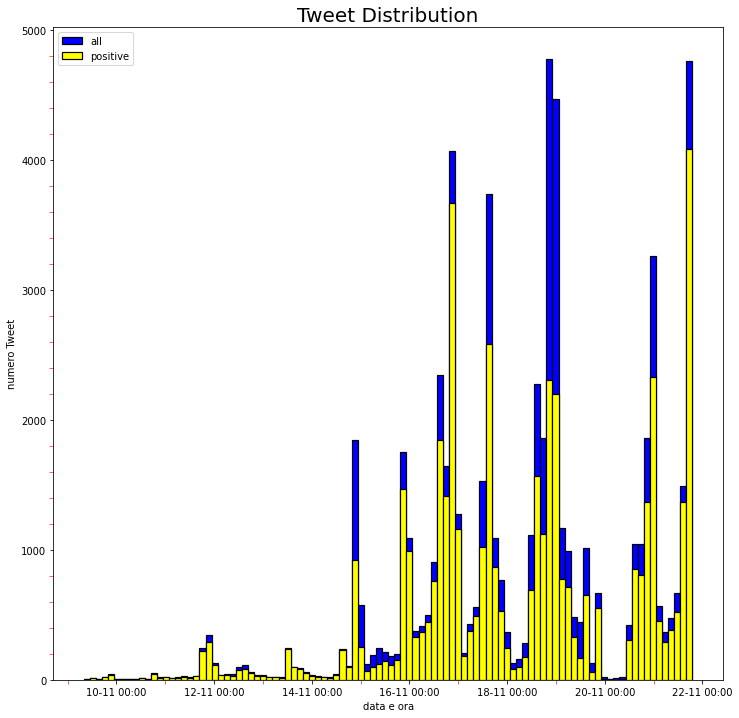

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from dateutil import tz
days=mdates.DayLocator() # every day
hours=mdates.HourLocator()
datetimes= pd.to_datetime(df['date_norm'], format="%Y-%m-%d %H:%M:%S")
dates = mdates.date2num(datetimes)
datetimes_p= pd.to_datetime(df_p['date_norm'], format="%Y-%m-%d %H:%M:%S")
dates_p = mdates.date2num(datetimes_p)
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))
n, bins, patches =ax.hist(dates, bins=100, color='blue', edgecolor='black', linewidth=1.2, label='all')
ax.hist(dates_p, bins=bins, color='yellow', edgecolor='black', linewidth=1.2, label='positive')
bin_max = np.where(n == n.max())
maxbins = mdates.num2date(bins[bin_max][0])
max_date_time = maxbins.strftime("%d/%m/%Y, %H:%M:%S")
print('maxbin', max_date_time)
order = np.argsort(n)[::-1]#
print("4 highest bins:", n[order][:4])
print("  their ranges:", [ (bins[i], bins[i+1])   for i in order[:4]])
ranges=[((mdates.num2date(bins[i])).strftime("%d/%m/%Y, %H:%M:%S"), (mdates.num2date(bins[i+1])).strftime("%d/%m/%Y, %H:%M:%S"))   for i in order[:4]]
prova = mdates.num2date(bins[bin_max][0])
date_time = prova.strftime("%d/%m/%Y, %H:%M:%S")
print("date and time:",date_time)
plt.gca().set(ylabel = 'numero Tweet',xlabel = 'data e ora')
#plt.grid()
# remove the minor xtick labels set by pandas.plot
#ax2.set_xticklabels([], minor = True)
# turn the minor ticks created by pandas.plot off
plt.minorticks_on()
# Define the date format
date_form = mdates.DateFormatter("%d-%m %H:%M")
ax.xaxis.set_major_formatter(date_form)
#ax.xaxis.set_minor_formatter(date_form)
ax.xaxis.set_minor_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.tick_params(which='minor', length=4, color='r')
plt.title('Tweet Distribution', fontsize=20)
#ax.legend(loc='upper left')
plt.legend(loc='upper left')
plt.show()

# 7. BOW WORDEMBEDDING LIME

In [ ]:
import tweepy
import numpy as np
from tweepy import Stream, OAuthHandler
from tqdm.notebook import tqdm
# from tqdm import tqdm !! per Jupyter from tqdm.notebook non funziona, runnare questo
import pandas as pd
pd.set_option('display.max_colwidth', None) # setta il num. di caratteri visibili per ogni cella della colonna
# es. 50 = primi 50 caratteri
# None = testo completo

import io
import pprint
import os
import glob
import warnings
warnings.filterwarnings('ignore')

import nltk ### libreria di linguistica (Stanford)
from nltk.stem import WordNetLemmatizer #### individua la radice linguistica delle parole: non tronca le parole come un stamming
nltk.download('wordnet') ## tassonomia lingua inglese
nltk.download('stopwords')

import warnings
from tqdm import tqdm
from pprint import pprint
from gensim.models.phrases import Phrases
from nltk.corpus import stopwords
pd.set_option('display.max_colwidth', None)

connectors = stopwords.words('english')
stop = stopwords.words('english')

# connectors_ita = stopwords.words('italian')
# stop_ita = stopwords.words('italian')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
filepath = st_tone_root_dir + 'new_dataset.csv'
df_open = pd.read_csv(filepath)

In [ ]:
df = df_open.copy()

df['cleaned_text'] = df['text_nonl_hash_men_http_num_simb']
df['bin_y'] = df['compound'].apply(lambda c: '1' if c >=0 else '0')

df = df[['id', 'user', 'date', 'text', 'favorite_count',
       'hashtags', 'location', 'retweet', 'retweet_count', 'followers_count',
       'in_reply_to_status_id', 'user_mentions', 'date_norm', 'time_zone',
       'text_nonl', 'text_nonl_hash', 'text_nonl_hash_men',
       'text_nonl_hash_men_http', 'text_nonl_hash_men_http_num',
       'text_nonl_hash_men_http_num_simb', 'cleaned_text', 'text_lang', 'text_lan_code',
       'lang_confidence', 'prediction_reliable', 'Medvedev', 'Zverev',
       'Berrettini', 'Hurkacz', 'Sinner', 'Djokovic', 'Tsitsipas', 'Rublev',
       'Ruud', 'Norrie', 'ATP_Finals', 'topic', 'neg', 'neu',
       'pos', 'compound', 'bin_y']]

df.isna().sum()


id                                      0
user                                    0
date                                    0
text                                    0
favorite_count                          0
hashtags                                0
location                            18978
retweet                                 0
retweet_count                           0
followers_count                         0
in_reply_to_status_id               42570
user_mentions                           0
date_norm                               0
time_zone                               0
text_nonl                               0
text_nonl_hash                          0
text_nonl_hash_men                      0
text_nonl_hash_men_http                 0
text_nonl_hash_men_http_num             0
text_nonl_hash_men_http_num_simb        0
cleaned_text                            0
text_lang                               0
text_lan_code                           0
lang_confidence                   

In [ ]:
df = df[~df['neg'].isna()]
raw_text = df[~df['cleaned_text'].isna()]['cleaned_text']

lemmatizer = WordNetLemmatizer()
####pulizia: sostituisco tutti i caratteri speciali con uno spazio
text = raw_text.str.lower()

###TOKENIZATION
df['token'] = text.str.split() ##text: series of list, text[0] list of string, text[0][0] string 

###LEMMATIZATION
df['ltoken'] = df.token.apply(lambda x: [lemmatizer.lemmatize(sent) for sent in x]) #text: series of list, text[0] list of string (lemmatized), text[0][0] string


## Word embedding similarity

### ngrammi

In [ ]:
##eng
df_en = df[df['text_lan_code'] == 'en']

bigram  = Phrases(df_en.ltoken, min_count=5, threshold=0.2, common_terms=connectors) #gensim 3, ad esempio "and" 
df_en['bigrams'] = df_en.ltoken.apply(lambda row: bigram[row])

ngram   = Phrases(df_en.bigrams, min_count=5, threshold=0.2, common_terms=connectors) # gensim 3
df_en['ngrams'] = df_en.bigrams.apply(lambda row: ngram[row])

df_en.bigrams = df_en.bigrams.apply(lambda bigr: [item for item in bigr if item not in stop])
df_en.ngrams = df_en.ngrams.apply(lambda ngr: [item for item in ngr if item not in stop])

df_en['bigrams_sent'] = df_en.bigrams.apply(lambda row: ' '.join(row))
df_en['ngrams_sent'] = df_en.ngrams.apply(lambda row: ' '.join(row))


In [ ]:
##italiano
# df_it = df[df['text_lan_code'] == 'it']

# bigram  = Phrases(df_it.ltoken, min_count=5, threshold=0.2, common_terms=connectors_ita) #gensim 3, ad esempio "and" 
# df_it['bigrams'] = df_it.ltoken.apply(lambda row: bigram[row])

# ngram   = Phrases(df_it.bigrams, min_count=5, threshold=0.2, common_terms=connectors_ita) # gensim 3
# df_it['ngrams'] = df_it.bigrams.apply(lambda row: ngram[row])

# df_it.bigrams = df_it.bigrams.apply(lambda bigr: [item for item in bigr if item not in stop_ita])
# df_it.ngrams = df_it.ngrams.apply(lambda ngr: [item for item in ngr if item not in stop_ita])

# df_it['bigrams_sent'] = df_it.bigrams.apply(lambda row: ' '.join(row))
# df_it['ngrams_sent'] = df_it.ngrams.apply(lambda row: ' '.join(row))


In [ ]:
df = df_en.copy()
# df = df.append(df_it.copy())
df.reset_index()

df.groupby('text_lan_code').size()

text_lan_code
en    49252
dtype: int64

In [ ]:
df['Review'] = df['ngrams_sent']
df = df[['id', 'user', 'date', 'text', 'favorite_count', 'hashtags', 'location',
       'retweet', 'retweet_count', 'followers_count', 'in_reply_to_status_id',
       'user_mentions', 'date_norm', 'time_zone', 'text_nonl',
       'text_nonl_hash', 'text_nonl_hash_men', 'text_nonl_hash_men_http',
       'text_nonl_hash_men_http_num', 'text_nonl_hash_men_http_num_simb',
       'text_lang', 'text_lan_code', 'lang_confidence',
       'prediction_reliable', 'Medvedev', 'Zverev', 'Berrettini', 'Hurkacz',
       'Sinner', 'Djokovic', 'Tsitsipas', 'Rublev', 'Ruud', 'Norrie',
       'ATP_Finals', 'topic', 'cleaned_text', 'token',
       'ltoken', 'bigrams', 'ngrams', 'bigrams_sent', 'Review', 
       'neg', 'neu', 'pos', 'compound', 'bin_y' ]]

df.to_csv(f'{output_root_dir}fullhope_output_dataframe.csv' , index=False, sep=',')       
df.columns

Index(['id', 'user', 'date', 'text', 'favorite_count', 'hashtags', 'location',
       'retweet', 'retweet_count', 'followers_count', 'in_reply_to_status_id',
       'user_mentions', 'date_norm', 'time_zone', 'text_nonl',
       'text_nonl_hash', 'text_nonl_hash_men', 'text_nonl_hash_men_http',
       'text_nonl_hash_men_http_num', 'text_nonl_hash_men_http_num_simb',
       'text_lang', 'text_lan_code', 'lang_confidence', 'prediction_reliable',
       'Medvedev', 'Zverev', 'Berrettini', 'Hurkacz', 'Sinner', 'Djokovic',
       'Tsitsipas', 'Rublev', 'Ruud', 'Norrie', 'ATP_Finals', 'topic',
       'cleaned_text', 'token', 'ltoken', 'bigrams', 'ngrams', 'bigrams_sent',
       'Review', 'neg', 'neu', 'pos', 'compound', 'bin_y'],
      dtype='object')

### most common words

In [ ]:
df_open = pd.read_csv(f'{output_root_dir}fullhope_output_dataframe.csv' , sep=',')
df_open.columns

Index(['id', 'user', 'date', 'text', 'favorite_count', 'hashtags', 'location',
       'retweet', 'retweet_count', 'followers_count', 'in_reply_to_status_id',
       'user_mentions', 'date_norm', 'time_zone', 'text_nonl',
       'text_nonl_hash', 'text_nonl_hash_men', 'text_nonl_hash_men_http',
       'text_nonl_hash_men_http_num', 'text_nonl_hash_men_http_num_simb',
       'text_lang', 'text_lan_code', 'lang_confidence', 'prediction_reliable',
       'Medvedev', 'Zverev', 'Berrettini', 'Hurkacz', 'Sinner', 'Djokovic',
       'Tsitsipas', 'Rublev', 'Ruud', 'Norrie', 'ATP_Finals', 'topic',
       'cleaned_text', 'token', 'ltoken', 'bigrams', 'ngrams', 'bigrams_sent',
       'Review', 'neg', 'neu', 'pos', 'compound', 'bin_y'],
      dtype='object')

In [ ]:
import pandas as pd

df = df_open.copy()

print(len(df))
df.drop(df[df["Review"].isna()].index, inplace=True)
print(len(df))

train_sentences_en = df[df['text_lan_code'] == 'en']['Review'].str.split()

# train_sentences_it = df[df['text_lan_code'] == 'it']['Review'].str.split()

print(len(train_sentences_en))
print(len(train_sentences_it))
print(len(train_sentences_en) + len(train_sentences_it))

49252
49071
49071
9994
59065


In [ ]:
dfp = df[df['bin_y'] == 1]
dfn = df[df['bin_y'] == 0]

train_sentences_p = dfp[dfp['text_lan_code'] == 'en']['Review'].str.split()
train_sentences_n = dfn[df['text_lan_code'] == 'en']['Review'].str.split()

print(len(dfp))
print(len(dfn))
print(len(df) - len(dfp) - len(dfn))

39653
9418
0


In [ ]:
from collections import Counter
c = Counter()
for sentence in train_sentences_en:
    c.update(sentence)

print('full')
print(f'Most common words in the corpus: {c.most_common(10)}\n')
print(f'Number of different words in the corpus: {len(c)}')

c = Counter()
for sentence in train_sentences_p:
    c.update(sentence)

print('positive')
print(f'Most common words in the corpus: {c.most_common(10)}\n')
print(f'Number of different words in the corpus: {len(c)}')

c = Counter()
for sentence in train_sentences_n:
    c.update(sentence)

print('negative')
print(f'Most common words in the corpus: {c.most_common(10)}\n')
print(f'Number of different words in the corpus: {len(c)}')

full
Most common words in the corpus: [('sinner', 2394), ('zverev', 1581), ('rublev', 1579), ('u', 1285), ('djokovic', 1107), ('wa', 1106), ('match', 1010), ('medvedev', 949), ('final', 941), ('win', 852)]

Number of different words in the corpus: 20924
positive
Most common words in the corpus: [('sinner', 1803), ('zverev', 1219), ('rublev', 1184), ('u', 1097), ('djokovic', 983), ('final', 883), ('match', 793), ('win', 788), ('medvedev', 715), ('wa', 706)]

Number of different words in the corpus: 17487
negative
Most common words in the corpus: [('let_me_understand_gosar_s_creepy', 708), ('anime_of_murder_and_such_is_ok_but_john', 708), ('katko_is_the_sinner_for_negotiating_and_voting', 708), ('infrastructure_the_ha_once_again_abdicated_his_leadership', 708), ('insane_asylum', 708), ('sinner', 591), ('sascha_soar_into_the_final_defeat', 512), ('novak_djokovic_to_reach_the_final', 512), ('wa', 400), ('rublev', 395)]

Number of different words in the corpus: 9215


In [ ]:
# c = Counter()
# for sentence in train_sentences_it:
#     c.update(sentence)
# print(f'Most common words in the corpus: {c.most_common(10)}\n')
# print(f'Number of different words in the corpus: {len(c)}')

Most common words in the corpus: [('zverev', 873), ('matteo_mi_dispiace_per_questa_situazione_e_per_quello_che_stai_passando', 832), ('sicuro_non_è_un_momento_facile_e_non_vorrei', 832), ('amico_come_te_stesse_vivendo_tutto_ciò', 832), ('sinner', 584), ('jannik', 506), ('matteo', 353), ('medvedev', 336), ('matteo_sei_un_idolo_bravissimo', 321), ('partita', 284)]

Number of different words in the corpus: 8880


### train a vector model with w2v and fastText

In [ ]:
# !pip install gensim -U

In [ ]:
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors 

#sg=0 (skipgram) ---> CBOW 
# %time w2v_model_it = Word2Vec(sg=0, hs=1, sentences=train_sentences_it, size=100, window=5, min_count=5, iter=5) #gensim 3
# %time ft_model_it = FastText(sg=0, hs=1, sentences=train_sentences_it, size=100, window=5, min_count=5, iter=5, min_n=3, max_n=6) #gensim 3
%time w2v_model_en = Word2Vec(sg=0, hs=1, sentences=train_sentences_en, size=100, window=5, min_count=5, iter=5) #gensim 3
%time ft_model_en = FastText(sg=0, hs=1, sentences=train_sentences_en, size=100, window=5, min_count=5, iter=5, min_n=3, max_n=6) #gensim 3

%time w2v_model_p = Word2Vec(sg=0, hs=1, sentences=train_sentences_p, size=100, window=5, min_count=5, iter=5) #gensim 3
%time ft_model_p = FastText(sg=0, hs=1, sentences=train_sentences_p, size=100, window=5, min_count=5, iter=5, min_n=3, max_n=6) #gensim 3

%time w2v_model_n = Word2Vec(sg=0, hs=1, sentences=train_sentences_n, size=100, window=5, min_count=5, iter=5) #gensim 3
%time ft_model_n = FastText(sg=0, hs=1, sentences=train_sentences_n, size=100, window=5, min_count=5, iter=5, min_n=3, max_n=6) #gensim 3

# w2v_model_it.wv.save_word2vec_format(models_root_dir+'w2v_model_it.bin', binary=True)
# ft_model_it.wv.save_word2vec_format(models_root_dir+'ft_model_it.vec', binary=False)
w2v_model_p.wv.save_word2vec_format(models_root_dir+'w2v_model_p.bin', binary=True)
ft_model_p.wv.save_word2vec_format(models_root_dir+'ft_model_p.vec', binary=False)

w2v_model_n.wv.save_word2vec_format(models_root_dir+'w2v_model_n.bin', binary=True)
ft_model_n.wv.save_word2vec_format(models_root_dir+'ft_model_n.vec', binary=False)

w2v_model_en.wv.save_word2vec_format(models_root_dir+'w2v_model_en.bin', binary=True)
ft_model_en.wv.save_word2vec_format(models_root_dir+'ft_model_en.vec', binary=False)

CPU times: user 7.9 s, sys: 58.9 ms, total: 7.96 s
Wall time: 5.17 s
CPU times: user 38 s, sys: 595 ms, total: 38.6 s
Wall time: 23.3 s
CPU times: user 5.83 s, sys: 56.4 ms, total: 5.89 s
Wall time: 3.87 s
CPU times: user 28.2 s, sys: 127 ms, total: 28.4 s
Wall time: 16.1 s
CPU times: user 1.54 s, sys: 25.8 ms, total: 1.57 s
Wall time: 1.14 s
CPU times: user 6.74 s, sys: 73.4 ms, total: 6.82 s
Wall time: 4.16 s


### most similar words

In [ ]:
df['sentiment'] = 

Index(['id', 'user', 'date', 'text', 'favorite_count', 'hashtags', 'location',
       'retweet', 'retweet_count', 'followers_count', 'in_reply_to_status_id',
       'user_mentions', 'date_norm', 'time_zone', 'text_nonl',
       'text_nonl_hash', 'text_nonl_hash_men', 'text_nonl_hash_men_http',
       'text_nonl_hash_men_http_num', 'text_nonl_hash_men_http_num_simb',
       'text_lang', 'text_lan_code', 'lang_confidence', 'prediction_reliable',
       'Medvedev', 'Zverev', 'Berrettini', 'Hurkacz', 'Sinner', 'Djokovic',
       'Tsitsipas', 'Rublev', 'Ruud', 'Norrie', 'ATP_Finals', 'topic',
       'cleaned_text', 'token', 'ltoken', 'bigrams', 'ngrams', 'bigrams_sent',
       'Review', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

In [ ]:
da = 0
a = 1

print(f'most {a-da} similar words by player')
print('')


print('#################################      w2v ##################################')
print('--------------full--------------')
print(f"sinner: {w2v_model_en.wv.most_similar('sinner')[da:a]}")
print(f"medvedev: {w2v_model_en.wv.most_similar('medvedev')[da:a]}")
print(f"zverev: {w2v_model_en.wv.most_similar('zverev')[da:a]}")
print(f"djokovic: {w2v_model_en.wv.most_similar('djokovic')[da:a]}")
print('')

print('--------------positive--------------')
print(f"sinner: {w2v_model_p.wv.most_similar('sinner')[da:a]}")
print(f"medvedev: {w2v_model_p.wv.most_similar('medvedev')[da:a]}")
print(f"zverev: {w2v_model_p.wv.most_similar('zverev')[da:a]}")
print(f"djokovic: {w2v_model_p.wv.most_similar('djokovic')[da:a]}")
print('')

print('--------------negative--------------')
print(f"sinner: {w2v_model_n.wv.most_similar('sinner')[da:a]}")
print(f"medvedev: {w2v_model_n.wv.most_similar('medvedev')[da:a]}")
print(f"zverev: {w2v_model_n.wv.most_similar('zverev')[da:a]}")
print(f"djokovic: {w2v_model_n.wv.most_similar('djokovic')[da:a]}")

print('')
print('')

print('#################################  ft   ##################################')
print('--------------full--------------')
print(f"sinner: {ft_model_en.wv.most_similar('sinner')[da:a]}")
print(f"medvedev: {ft_model_en.wv.most_similar('medvedev')[da:a]}")
print(f"zverev: {ft_model_en.wv.most_similar('zverev')[da:a]}")
print(f"djokovic: {ft_model_en.wv.most_similar('djokovic')[da:a]}")
print('')

print('--------------positive--------------')
print(f"sinner: {ft_model_p.wv.most_similar('sinner')[da:a]}")
print(f"medvedev: {ft_model_p.wv.most_similar('medvedev')[da:a]}")
print(f"zverev: {ft_model_p.wv.most_similar('zverev')[da:a]}")
print(f"djokovic: {ft_model_p.wv.most_similar('djokovic')[da:a]}")
print('')

print('--------------negative--------------')
print(f"sinner: {ft_model_n.wv.most_similar('sinner')[da:a]}")
print(f"medvedev: {ft_model_n.wv.most_similar('medvedev')[da:a]}")
print(f"zverev: {ft_model_n.wv.most_similar('zverev')[da:a]}")
print(f"djokovic: {ft_model_n.wv.most_similar('djokovic')[da:a]}")


most 1 similar words by player

#################################      w2v ##################################
--------------full--------------
sinner: [('crowd', 0.8360240459442139)]
medvedev: [('set', 0.7991044521331787)]
zverev: [('novak', 0.8115599751472473)]
djokovic: [('free', 0.7436234354972839)]

--------------positive--------------
sinner: [('feel', 0.8392145037651062)]
medvedev: [('break', 0.8276182413101196)]
zverev: [('match', 0.8698792457580566)]
djokovic: [('top', 0.8430657386779785)]

--------------negative--------------
sinner: [('ha', 0.9852283000946045)]
medvedev: [('point', 0.9780462980270386)]
zverev: [('watch', 0.980766773223877)]
djokovic: [('today', 0.964573323726654)]


#################################  ft   ##################################
--------------full--------------
sinner: [('inner', 0.9765059351921082)]
medvedev: [('medved', 0.9741642475128174)]
zverev: [('zverevs', 0.9285239577293396)]
djokovic: [('djoković', 0.9872832298278809)]

--------------posit

### PRIMO OUTPUT

In [ ]:
# sinner
# medvedev
# hurkacz
word = 'fuck'

print(f"players' similarity with worls: {word}")
print(f"")
print('--------------full--------------')
print(f"sinner:   {ft_model_en.wv.similarity('sinner', word)}") #il contesto è importante!!
print(f"medvedev: {ft_model_en.wv.similarity('medvedev', word)}") #il contesto è importante!!
print(f"hurkacz:  {ft_model_en.wv.similarity('hurkacz', word)}") #il contesto è importante!!
print(f"zverev:   {ft_model_en.wv.similarity('zverev', word)}") #il contesto è importante!!
print(f"djokovic: {ft_model_en.wv.similarity('djokovic', word)}") #il contesto è importante!!

print(f"")
print('--------------positive--------------')
print(f"sinner:   {ft_model_p.wv.similarity('sinner', word)}") #il contesto è importante!!
print(f"medvedev: {ft_model_p.wv.similarity('medvedev', word)}") #il contesto è importante!!
print(f"hurkacz:  {ft_model_p.wv.similarity('hurkacz', word)}") #il contesto è importante!!
print(f"zverev:   {ft_model_p.wv.similarity('zverev', word)}") #il contesto è importante!!
print(f"djokovic: {ft_model_p.wv.similarity('djokovic', word)}") #il contesto è importante!!

print(f"")
print('--------------negative--------------')
print(f"sinner:   {ft_model_n.wv.similarity('sinner', word)}") #il contesto è importante!!
print(f"medvedev: {ft_model_n.wv.similarity('medvedev', word)}") #il contesto è importante!!
print(f"hurkacz:  {ft_model_n.wv.similarity('hurkacz', word)}") #il contesto è importante!!
print(f"zverev:   {ft_model_n.wv.similarity('zverev', word)}") #il contesto è importante!!
print(f"djokovic: {ft_model_n.wv.similarity('djokovic', word)}") #il contesto è importante!!



players' similarity with worls: fuck

--------------full--------------
sinner:   0.2782207429409027
medvedev: 0.05301833152770996
hurkacz:  0.021547099575400352
zverev:   0.3486464321613312
djokovic: 0.17571048438549042

--------------positive--------------
sinner:   0.40086042881011963
medvedev: 0.25846418738365173
hurkacz:  -0.00796792283654213
zverev:   0.32292917370796204
djokovic: 0.19750414788722992

--------------negative--------------
sinner:   0.7845971584320068
medvedev: 0.3353504240512848
hurkacz:  0.6584069132804871
zverev:   0.6377624273300171
djokovic: 0.4710964858531952


## Embedding ML

In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=eb1389b479bb4176545e081eae17cb21729332e7ce291df481c45b498f73296f
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from __future__ import print_function
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics

In [ ]:
import pandas as pd
df_open = pd.read_csv(f'{output_root_dir}fullhope_output_dataframe.csv' , sep=',')
df.columns

Index(['id', 'user', 'date', 'text', 'favorite_count', 'hashtags', 'location',
       'retweet', 'retweet_count', 'followers_count', 'in_reply_to_status_id',
       'user_mentions', 'date_norm', 'time_zone', 'text_nonl',
       'text_nonl_hash', 'text_nonl_hash_men', 'text_nonl_hash_men_http',
       'text_nonl_hash_men_http_num', 'text_nonl_hash_men_http_num_simb',
       'text_lang', 'text_lan_code', 'lang_confidence', 'prediction_reliable',
       'Medvedev', 'Zverev', 'Berrettini', 'Hurkacz', 'Sinner', 'Djokovic',
       'Tsitsipas', 'Rublev', 'Ruud', 'Norrie', 'ATP_Finals', 'topic',
       'cleaned_text', 'token', 'ltoken', 'bigrams', 'ngrams', 'bigrams_sent',
       'Review', 'neg', 'neu', 'pos', 'compound', 'bin_y'],
      dtype='object')

In [ ]:
df = df_open.copy()
# df['bin_y'] = df['compound'].apply(lambda c: '1' if c >=0 else '0')

df = df[df['text_lan_code'] == 'en']
print(len(df))

df = df[~df['Review'].isna()]
print(df['Review'].isna().sum())
train_sentences = df['Review'].tolist()
y = df['bin_y'].tolist()

class_names = ['Negative','Positive']

dfp = df[df['bin_y'] == 1]
dfn = df[df['bin_y'] == 0]

train_sentences_p = dfp[dfp['text_lan_code'] == 'en']['Review'].str.split()
train_sentences_n = dfn[df['text_lan_code'] == 'en']['Review'].str.split()

49252
0


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_sentences, y, stratify=y, test_size=0.3, random_state=42)

### vectorization


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)

### classifier fit

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(class_weight='balanced')

model.fit(train_vectors, y_train)

print('training')
pred = model.predict(test_vectors)
print(classification_report(y_test, pred))
print(sklearn.metrics.f1_score(y_test, pred, average='weighted'))

print('test')
pred = model.predict(test_vectors)
print(classification_report(y_test, pred))
print(sklearn.metrics.f1_score(y_test, pred, average='weighted'))

training
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      2826
           1       0.95      0.99      0.97     11896

    accuracy                           0.95     14722
   macro avg       0.94      0.88      0.90     14722
weighted avg       0.95      0.95      0.94     14722

0.9430708693521114
test
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      2826
           1       0.95      0.99      0.97     11896

    accuracy                           0.95     14722
   macro avg       0.94      0.88      0.90     14722
weighted avg       0.95      0.95      0.94     14722

0.9430708693521114


## Explainability


### Local explanations

In [ ]:
# !pip install lime

### positivi

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, model)
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

### Global explanations

In [ ]:
x_test[idx]

AttributeError: ignored

In [ ]:
from tqdm import tqdm

more_pos = dict()
for idx in tqdm(range(100)):
  exp = explainer.explain_instance(x_test[idx], c.predict_proba, num_features=10, labels=[0,1])
  for i in exp.as_list(label=1):
    if i[0] in more_pos.keys():
      more_pos[i[0]] = more_pos[i[0]]+i[1]
    else:
      more_pos[i[0]] = i[1]

100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


In [ ]:
df_pos = pd.DataFrame(more_pos.items(), columns=['term','weight']) #create a dataframe from the dict
df_pos = df_pos.sort_values('weight', ascending=False).head(60)

from gensim.models import KeyedVectors 
embeddings = KeyedVectors.load_word2vec_format(models_root_dir+'ft_model_en.vec', binary=False) #import the ft model

vectors = []
to_exclude = []
for t in df_pos.term:
  if t in embeddings.wv.vocab:
    vectors.append(embeddings.wv[t])
  else:
    to_exclude.append(t)

df_pos = df_pos[~df_pos.term.isin(to_exclude)]
df_pos['vector'] = vectors


### Visualise Embeddings with UMAP

[UMAP](https://umap-learn.readthedocs.io/en/latest/): Uniform Manifold Approximation and Projection for Dimension Reduction

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 32.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=f16eb1aa343bcc147d6e008cd613125f6f89012a375ad3fbbfcd10aac4dbf23d
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=ef8b576a84f34072c2ca07dcfd678827defbdcb074f94d9dace21f5f1aaaae3d
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


#### Define a function to restrict vocab to keywords to speed up UMap

In [ ]:
 def restrict_w2v(w2v, restricted_word_set):
    w2v.most_similar(list(restricted_word_set)[0]) #to inizialize norms
    new_vectors = []
    new_vocab = {}
    new_index2entity = []
    new_vectors_norm = []

    for i in range(len(w2v.vocab)):
        word = w2v.index2entity[i]
        vec = w2v.vectors[i]
        vocab = w2v.vocab[word]
        vec_norm = w2v.vectors_norm[i]
        if word in restricted_word_set:
            vocab.index = len(new_index2entity)
            new_index2entity.append(word)
            new_vocab[word] = vocab
            new_vectors.append(vec)
            new_vectors_norm.append(vec_norm)

    w2v.vocab = new_vocab
    w2v.vectors = np.array(new_vectors)
    w2v.index2entity = np.array(new_index2entity)
    w2v.index2word = np.array(new_index2entity)
    w2v.vectors_norm = np.array(new_vectors_norm)

#### Define a function to train UMAP

In [ ]:
import umap
def train_umap(model):
    random.seed(42)
    np.random.seed(42)
    X = model[model.wv.vocab]
    reducer = umap.UMAP(n_neighbors=50, metric='cosine', learning_rate=0.01,
                        n_epochs=50, spread=1, min_dist=0.2, random_state=42)
    X = model[model.wv.vocab]
    embedding = reducer.fit_transform(X)

    df = pd.DataFrame(embedding)
    df['token'] = model.vocab
    df.columns  = ['x', 'y', 'token']
    return df

#### Reduce the voceb, train UMAP and print the two-dimensional vectors

In [ ]:
!pip install adjusttext

  Created wheel for adjusttext: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=9e370beb43c1272831b5016e56d2b6be4b9ae3d8677d5e54d6dee6b15a38bc22
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjusttext


In [ ]:
import pandas as pd
import numpy as np
import random
from adjustText import adjust_text

#take only the relevant vectors and restrict the embeddings vocab
relevant_vectors_p = df_pos.term.tolist()
word_set_p = {w for w in relevant_vectors_p if w in embeddings.wv.vocab}
restrict_w2v(embeddings, word_set_p)

#train umap with the relevan vectors
relevant_vectors_2d_p = train_umap(embeddings)
print(relevant_vectors_2d_p.head())


          x         y                      token
0  1.926757  5.399789                     zverev
1  1.880055  4.050769                      match
2  4.016988  0.823627                      final
3  7.035022  4.264997       amp_grande_ibra_uvek
4  4.990826  6.409891  je_zadovoljstvo_videti_te


#### plot UMAP values

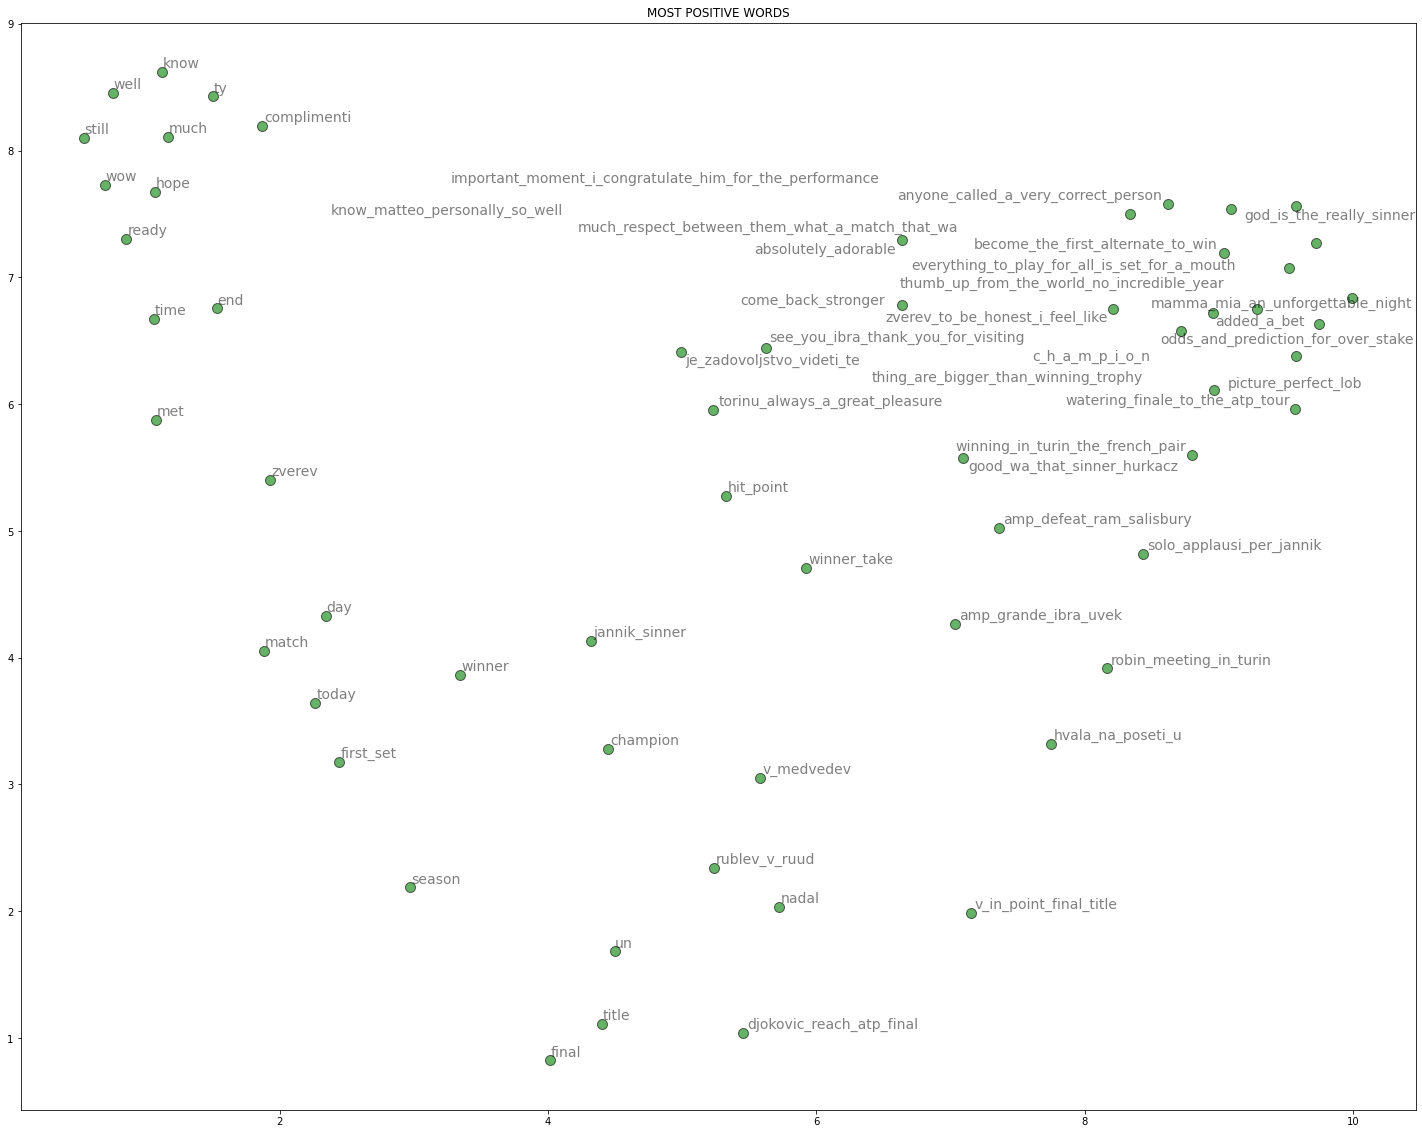

In [ ]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib
random.seed(42)
plt.rcParams['figure.figsize'] = 25, 20

text = []
for index, row in relevant_vectors_2d_p.iterrows():
    plt.scatter(row['x'], row['y'], c='g', alpha=0.6, marker='o', s=100, edgecolors='black')
    text.append(plt.annotate(row['token'], alpha=0.5, xy=(row['x'], row['y']), ha='right', va='bottom', size=14))
adjust_text(text)
plt.title("MOST POSITIVE WORDS")
plt.savefig(prj_root_dir + 'GRAFICI/umap')

<Figure size 1800x3600 with 0 Axes>

### distanza players

In [ ]:
w2vec_arr_medvedev = ft_model_en.wv['medvedev']
w2vec_arr_zverev = ft_model_en.wv['zverev']
w2vec_arr_berrettini = ft_model_en.wv['berrettini']
w2vec_arr_hurkacz = ft_model_en.wv['hurkacz']
w2vec_arr_sinner = ft_model_en.wv['sinner']
w2vec_arr_djokovic = ft_model_en.wv['djokovic']
w2vec_arr_tsitsipas = ft_model_en.wv['tsitsipas']
w2vec_arr_rublev = ft_model_en.wv['rublev']
w2vec_arr_ruud = ft_model_en.wv['ruud']
w2vec_arr_norrie = ft_model_en.wv['norrie']

In [ ]:
players_2vec = []
players_2vec.append(w2vec_arr_medvedev)
players_2vec.append(w2vec_arr_zverev)
players_2vec.append(w2vec_arr_berrettini)
players_2vec.append(w2vec_arr_hurkacz)
players_2vec.append(w2vec_arr_sinner)
players_2vec.append(w2vec_arr_djokovic)
players_2vec.append(w2vec_arr_tsitsipas)
players_2vec.append(w2vec_arr_rublev)
players_2vec.append(w2vec_arr_ruud)
players_2vec.append(w2vec_arr_ruud)



# 8. SocialNetwork Analisys